In [1]:
import pandas as pd
import seaborn as sns
import open3d as o3d
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = pd.read_csv('vaihingen_train_without_ground.csv')

In [3]:
dataset

,X,Y,Z,Intensity,return_number,number_of_returns,label
0,496848.91,5419403.58,265.46,19,1,1,1
1,496848.92,5419403.97,265.43,24,1,1,1
2,496848.93,5419404.35,265.40,31,1,1,1
3,496848.94,5419404.73,265.36,33,1,1,1
4,496849.34,5419405.72,265.30,44,1,1,1
...,...,...,...,...,...,...,...
506842,497067.61,5419442.02,260.30,255,1,1,6
506843,497067.62,5419442.47,260.28,243,1,1,7
506844,497067.64,5419442.89,260.03,237,1,1,7
506845,497067.65,5419443.29,259.84,113,1,1,7


In [4]:
points = dataset.iloc[:,0:3].values

In [5]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

In [6]:
o3d.visualization.draw_geometries([pcd],width=3920,height=2080)


[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
#ply_point_cloud = o3d.data.PLYPointCloud()
#pcd = o3d.io.read_point_cloud(ply_point_cloud.path)
with o3d.utility.VerbosityContextManager(
o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1,min_points=5,print_progress=True))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels/(max_label if max_label>0 else 1))
colors[labels<0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:,:3])
o3d.visualization.draw_geometries([pcd])
#print(colors)

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2261


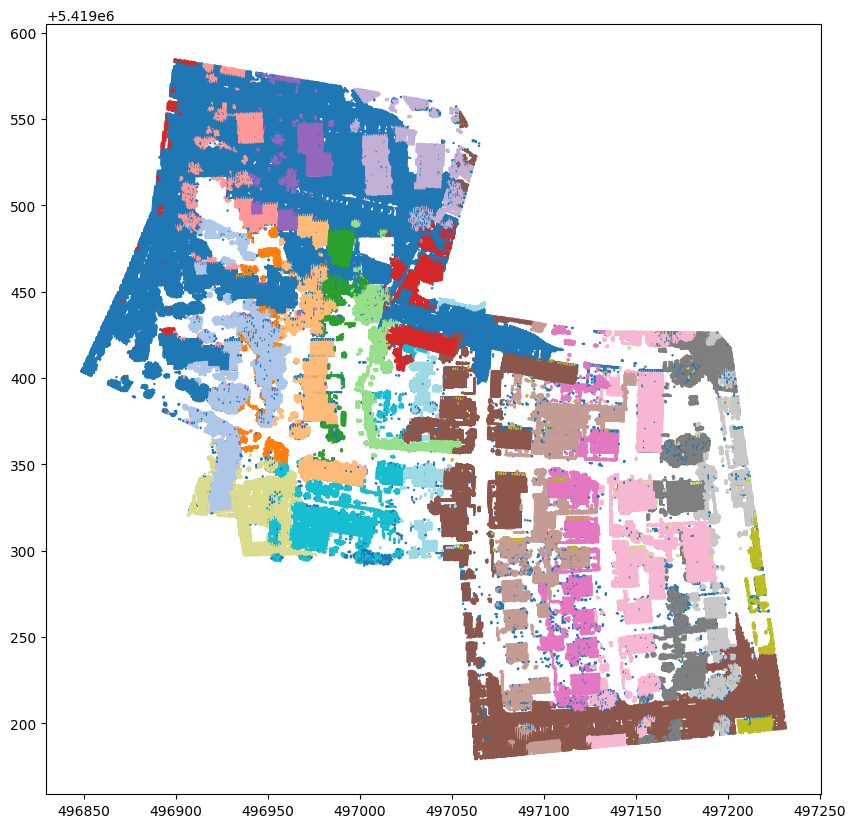

In [8]:
out_l = np.array(pcd.points)
fig = plt.figure(figsize=(10,10))
plt.scatter(out_l[:,0],out_l[:,1],c=labels,cmap='tab20',s=0.5)

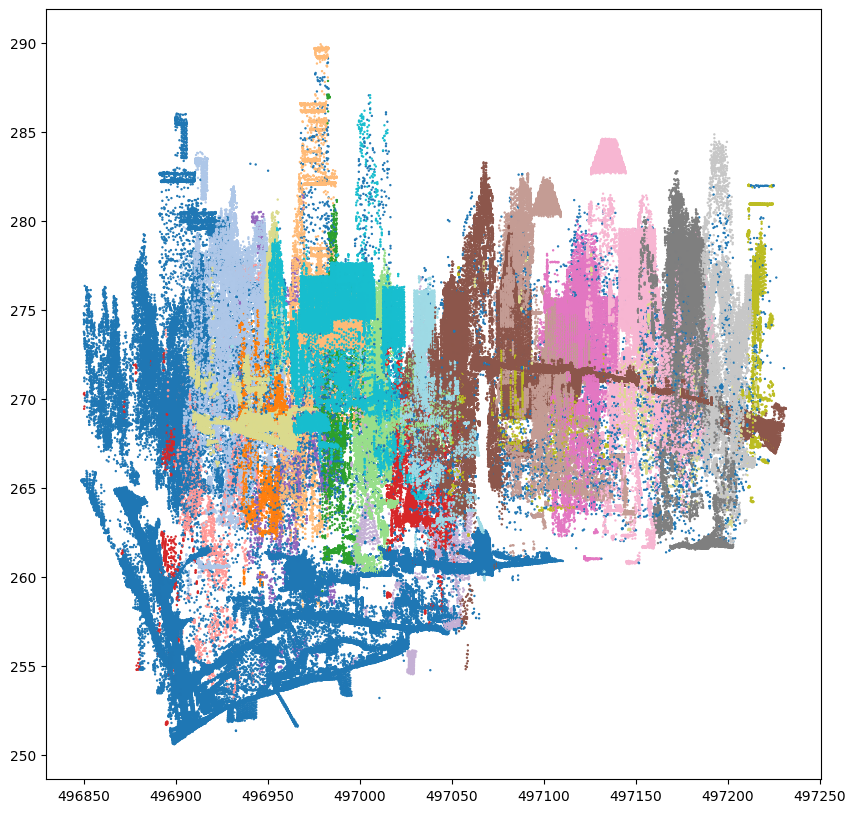

In [9]:
fig = plt.figure(figsize=(10,10))
plt.scatter(out_l[:,0],out_l[:,2],c=labels,cmap='tab20',s=0.5)


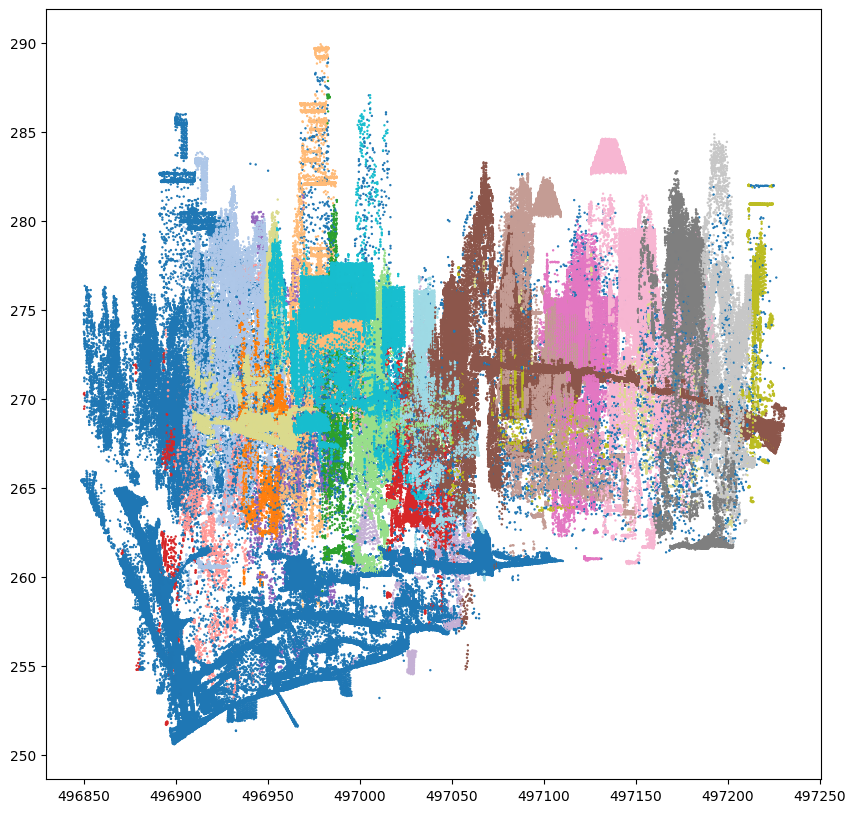

In [10]:
fig = plt.figure(figsize=(10,10))
plt.scatter(out_l[:,0],out_l[:,2],c=labels,cmap='tab20',s=0.5)


In [11]:
result_clust = pd.DataFrame(np.array(pcd.points),columns=['X','Y','Z'])
result_clust['Classification'] = labels
result_clust.to_csv('vai_clust_re.csv',header=True,index=False)

In [12]:
# KMeans

In [13]:
data_grid = dataset.iloc[:,0:4].values

In [14]:
data_grid

array([[4.96848910e+05, 5.41940358e+06, 2.65460000e+02, 1.90000000e+01],
       [4.96848920e+05, 5.41940397e+06, 2.65430000e+02, 2.40000000e+01],
       [4.96848930e+05, 5.41940435e+06, 2.65400000e+02, 3.10000000e+01],
       ...,
       [4.97067640e+05, 5.41944289e+06, 2.60030000e+02, 2.37000000e+02],
       [4.97067650e+05, 5.41944329e+06, 2.59840000e+02, 1.13000000e+02],
       [4.97067670e+05, 5.41944376e+06, 2.59880000e+02, 1.23000000e+02]])

In [15]:
import scipy.cluster
import sklearn.cluster
kmeans = sklearn.cluster.MiniBatchKMeans(
n_clusters=50,
init="k-means++",
compute_labels=True,
random_state=42,
batch_size=1024,
n_init = 3,
max_no_improvement = None,
max_iter=100,
).fit(data_grid)

In [16]:
fig = plt.figure(figsize=(10,10))
plt.scatter(out_l[:,0],out_l[:,1],c=y_clt,cmap='tab20',s=0.5)

NameError: name 'y_clt' is not defined

<Figure size 1000x1000 with 0 Axes>

In [17]:
y_clt = kmeans.predict(data_grid)
y_clt

array([47, 47, 47, ..., 14,  1,  1])

In [18]:
result_clust = pd.DataFrame(data_grid,columns=['X','Y','Z','Intensity'])
result_clust['Classification'] = y_clt
result_clust.to_csv('vai_clust_kmeans.csv',header=True,index=False)


In [19]:
pcd.estimate_normals(
search_param = o3d.geometry.KDTreeSearchParamHybrid(radius=10,max_nn=400))
o3d.visualization.draw_geometries([pcd],
                                 point_show_normal=True)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [20]:
assert(pcd.has_normals())

#using all defaults

oboxes = pcd.detect_planar_patches(
normal_variance_threshold_deg=60,
coplanarity_deg=75,
outlier_ratio=0.75,
min_plane_edge_length=0,
min_num_points=0,
search_param=o3d.geometry.KDTreeSearchParamKNN(knn=100))

geometries=[]
for obox in oboxes:
    mesh=o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox,scale=[1,1,0.0001])
    mesh.paint_uniform_color(obox.color)
    geometries.append(mesh)
    geometries.append(obox)
geometries.append(pcd)

o3d.visualization.draw_geometries(geometries)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
